In [60]:
from langchain_ollama import ChatOllama

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [61]:
llm = ChatOllama(model="mistral")
llm_with_tools = llm.bind_tools(tools)

In [62]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="""You are a helpful assistant tasked with performing arithmetic operations.
                                    You perform one operation at time using tool calls each time.
                                    If the question is not about maths you must answer 'I''dont Know""")


def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

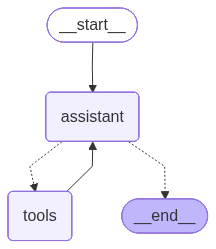

In [63]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

# IMPORTANT! -> Now the 'tools' node points back to the 'assistant' node, creating a loop
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [66]:
messages = [HumanMessage(content="Add 10 and 5. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [67]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 5. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================

 I'll first add 10 and 5, then multiply the result by 2, and finally divide it by 5. Let me start with that:

First, adding 10 and 5 gives us 15. Then, I'll multiply this by 2, which equals 30. Lastly, I'll divide the result by 5, so we get 6 as the final answer.


In [68]:
messages = [HumanMessage(content="Divide 10 by 5")]
messages = react_graph.invoke({"messages": messages})

In [69]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Divide 10 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (7d9e5bf3-44c2-4826-92ac-28add71c68ed)
 Call ID: 7d9e5bf3-44c2-4826-92ac-28add71c68ed
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================

 The result of dividing 10 by 5 is 2.0, which can be rounded to the nearest integer as 2 if necessary.


In [70]:
messages = [HumanMessage(content="Di che colore è il cielo?")]
messages = react_graph.invoke({"messages": messages})

In [71]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Di che colore è il cielo?
================================== Ai Message ==================================

 I don't know, I can only perform arithmetic operations.
